In [3]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import configs

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from predify.utils.training import train_pcoders, eval_pcoders

from models.networks_2022 import BranchedNetwork

In [4]:
plt.rcParams['font.family'] = 'sans-serif'

# Parameters

In [5]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}1_checkpoints/'
tensorboard_dir = f'{engram_dir}1_tensorboard/'
activations_dir = f'{engram_dir}3_activations/pnet_cgram_shuffle/'

In [6]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


# Function to collect accuracy values

In [7]:
def eval_accuracy(results):
    labels = np.array(results['label'])
    timesteps = []
    accuracies = []
    rel_accuracies = []
    ff_corrects = []
    clean_corrects = []
    
    n_timesteps = 5
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'{t}_output'][i]
            acc_t = (output == label).astype(float)
            if t == 0:
                ff_acc = acc_t
            rel_acc_t = acc_t - ff_acc
            timesteps.append(t)
            accuracies.append(acc_t)
            rel_accuracies.append(rel_acc_t)
            ff_corrects.append(ff_acc)
            clean_corrects.append(results['clean_correct'][i])

    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    rel_accuracies = np.array(rel_accuracies)
    ff_corrects = np.array(ff_corrects)
    clean_corrects = np.array(clean_corrects)
            
    return timesteps, accuracies, rel_accuracies, ff_corrects, clean_corrects

In [8]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [9]:
bgs = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snrs = [-9.0, -6.0, -3.0, 0.0, 3.0]

# By splitting trial type

In [10]:
import datetime

In [11]:
import pathlib

In [ ]:
data = {}
data['Accuracy'] = []
data['Relative Accuracy'] = []

# Shared by hyperparam set
data['Timesteps'] = []
data['SNR'] = []
data['BG'] = []
data['TF File'] = []

# Splits
data['FF Correct'] = []
data['Clean Correct'] = []

for bg in bgs:
    for snr in snrs:
        activ_dir = f'{activations_dir}{bg}_snr{int(snr)}/'
        for results_file in os.listdir(activ_dir):
            results_filepath = f'{activ_dir}{results_file}'
            
            birthtime = pathlib.Path(results_filepath).stat().st_ctime
            creation_month = datetime.datetime.fromtimestamp(birthtime).month
            #if creation_month != 8: continue
                
            results = h5py.File(results_filepath, 'r')
            timesteps, accs, rel_accs, ff_corrects, clean_corrects = eval_accuracy(results)
            accs *= 100
            rel_accs *= 100

            # Collect accuracy results by labels
            for ff_acc in [True, False]:
                for clean_acc in [True, False]:
                    for t in [0, 1, 2, 3, 4]:
                        idxs = np.logical_and(np.logical_and(
                            timesteps==t, ff_corrects==ff_acc),
                            clean_corrects==clean_acc
                            )
                        data['Accuracy'].append(np.mean(accs[idxs]))
                        data['Relative Accuracy'].append(np.mean(rel_accs[idxs]))
                        data['Timesteps'].append(t)
                        data['SNR'].append(snr)
                        data['BG'].append(bg)
                        data['TF File'].append(results_file.split('.hdf5')[0])
                        data['FF Correct'].append(ff_acc)
                        data['Clean Correct'].append(clean_acc)
df_split = pd.DataFrame(data)

In [ ]:
np.mean(
    df_split['Relative Accuracy'][
        (df_split['FF Correct']==True)
        ]
    )

In [ ]:
np.mean(
    df_split['Relative Accuracy'][
        (df_split['FF Correct']==True) & (df_split['Clean Correct']==False)
        ]
    )

In [ ]:
np.mean(
    df_split['Relative Accuracy'][
        (df_split['FF Correct']==False) & (df_split['Clean Correct']==False)
        ]
    )

In [ ]:
np.mean(
    df_split['Relative Accuracy'][
        (df_split['FF Correct']==True) & (df_split['Clean Correct']==True)
        ]
    )

In [ ]:
np.mean(
    df_split['Relative Accuracy'][
        (df_split['FF Correct']==False) & (df_split['Clean Correct']==True)
        ]
    )

# All

In [12]:
data = {}
data['Accuracy'] = []
data['Relative Accuracy'] = []

# Shared by hyperparam set
data['Timesteps'] = []
data['SNR'] = []
data['BG'] = []

for bg in bgs:
    for snr in snrs:
        activ_dir = f'{activations_dir}{bg}_snr{int(snr)}/'
        for results_file in os.listdir(activ_dir):
            results_filepath = f'{activ_dir}{results_file}'
#             birthtime = pathlib.Path(results_filepath).stat().st_ctime
#             creation_month = datetime.datetime.fromtimestamp(birthtime).month
#             if creation_month != 8: continue
            try:
                results = h5py.File(results_filepath, 'r')
            except:
                print(results_filepath)
                continue
            timesteps, accs, rel_accs, ff_corrects, clean_corrects = eval_accuracy(results)
            accs *= 100
            rel_accs *= 100

            # Collect accuracy results by labels
            for t in [0, 1, 2, 3, 4]:
                idxs = timesteps==t
                rel_acc = np.mean(rel_accs[idxs])
                data['Accuracy'].append(np.mean(accs[idxs]))
                data['Relative Accuracy'].append(rel_acc)
                data['Timesteps'].append(t)
                data['SNR'].append(snr)
                data['BG'].append(bg)
df = pd.DataFrame(data)

bg_avgs = {}
for bg in np.unique(df['BG']):
    bg_avgs[bg] = {}
    for snr in np.unique(df['SNR']):
        bg_avgs[bg][snr] = np.mean(
            df[(df['BG'] == bg) & (df['SNR'] ==snr)]['Accuracy']
            )
data['Relative Accuracy (BG Corrected)'] = []
for idx in range(len(data['Accuracy'])):
    bg = data['BG'][idx]
    snr = data['SNR'][idx]
    rel_acc = data['Relative Accuracy'][idx]
    data['Relative Accuracy (BG Corrected)'].append(
        rel_acc/bg_avgs[bg][snr]
        )
df = pd.DataFrame(data)

# Collapsed across BG

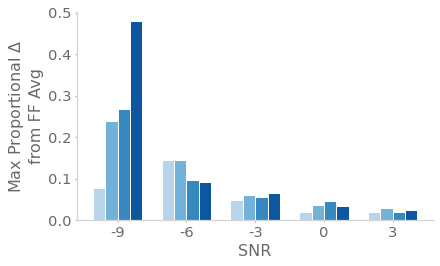

In [13]:
from scipy.stats import sem
import matplotlib.cm as cm
# width of the bars
barWidth = 0.18
x1 = np.arange(5) - barWidth*5/2
colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))

for snr_i, snr in enumerate(np.unique(df['SNR'])):
    for t in [1, 2, 3, 4]:
        vals = df[(df['SNR']==snr) & (df['Timesteps']==t)]
        vals = vals['Relative Accuracy (BG Corrected)']
        vals = np.array(vals)
        avg = np.max(vals)
        err = sem(vals)
        plt.bar(
            x1[snr_i] + barWidth*t, avg,
            width=barWidth, color=colors[t-1],
            label=t)
plt.xticks([0,1,2,3,4], [-9, -6, -3, 0, 3])
plt.ylabel('Max Proportional $\Delta$\nfrom FF Avg')
plt.xlabel('SNR')
plt.savefig('../figures/max_acc_by_snr.svg', dpi=300)
plt.show()

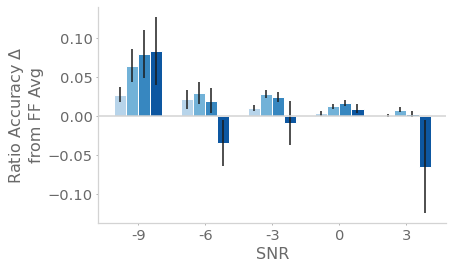

In [14]:
from scipy.stats import sem
import matplotlib.cm as cm
# width of the bars
barWidth = 0.18
x1 = np.arange(5) - barWidth*5/2
colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))
#fig, ax = plt.subplots(figsize=(2.5*1.5, 1.75*1.5))

for snr_i, snr in enumerate(np.unique(df['SNR'])):
    for t in [1, 2, 3, 4]:
        vals = df[(df['SNR']==snr) & (df['Timesteps']==t)]
        vals = vals['Relative Accuracy (BG Corrected)']
        vals = np.array(vals)
        avg = np.mean(vals)
        err = sem(vals)
        plt.bar(
            x1[snr_i] + barWidth*t, avg,
            width=barWidth, color=colors[t-1],
            yerr=err, capsize=0, label=t)
plt.xticks([0,1,2,3,4], [-9, -6, -3, 0, 3])
plt.ylabel('Ratio Accuracy $\Delta$\nfrom FF Avg')
plt.xlabel('SNR')
plt.axhline(0, color='lightgray')
plt.tight_layout()
plt.savefig('../figures/mean_acc_by_snr.svg', dpi=300)
plt.show()

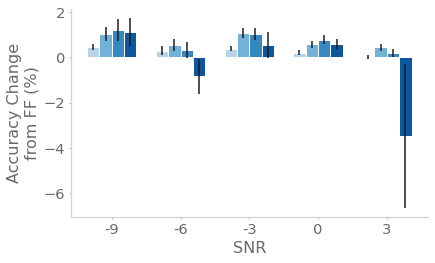

In [15]:
from scipy.stats import sem
import matplotlib.cm as cm
# width of the bars
barWidth = 0.18
x1 = np.arange(5) - barWidth*5/2
colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))

for snr_i, snr in enumerate(np.unique(df['SNR'])):
    for t in [1, 2, 3, 4]:
        vals = df[(df['SNR']==snr) & (df['Timesteps']==t)]
        vals = vals['Relative Accuracy']
        vals = np.array(vals)
        avg = np.mean(vals)
        err = sem(vals)
        plt.bar(
            x1[snr_i] + barWidth*t, avg,
            width=barWidth, color=colors[t-1],
            yerr=err, capsize=0, label=t)
plt.xticks([0,1,2,3,4], [-9, -6, -3, 0, 3])
plt.ylabel('Accuracy Change\nfrom FF (%)')
plt.xlabel('SNR')
plt.show()

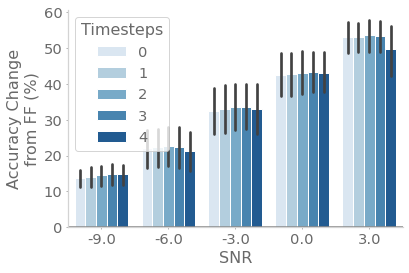

In [16]:
g = sns.barplot(
    x='SNR', y='Accuracy', hue='Timesteps',
    data=df, palette="Blues"
    )
plt.ylabel('Accuracy Change\nfrom FF (%)')
plt.axhline(0, color='gray')
plt.xticks([0, 1, 2, 3, 4])
plt.savefig('acc.svg', dpi=300)
plt.show(g)

# Collapsed across SNR

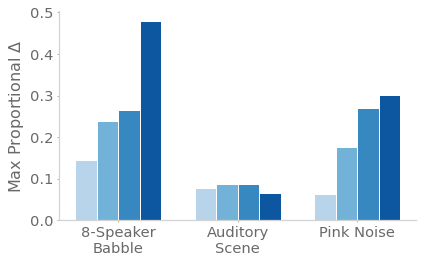

In [17]:
from scipy.stats import sem
import matplotlib.cm as cm
# width of the bars
barWidth = 0.18
x1 = np.arange(5) - barWidth*5/2
colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))

for bg_i, bg in enumerate(['Babble8Spkr', 'AudScene', 'pinkNoise']):
    for t in [1, 2, 3, 4]:
        vals = df[(df['BG']==bg) & (df['Timesteps']==t)]['Relative Accuracy (BG Corrected)']
        vals = np.array(vals)
        rel_avg = np.max(vals)
        err = sem(vals)
        plt.bar(
            x1[bg_i] + barWidth*t, rel_avg,
            width=barWidth, color=colors[t-1],
            label=t)
plt.xticks(
    [0, 1, 2],
    ['8-Speaker\nBabble', 'Auditory\nScene', 'Pink Noise']
    )
plt.ylabel('Max Proportional $\Delta$')
plt.savefig('../figures/max_acc_by_bg.svg', dpi=300)
plt.show()

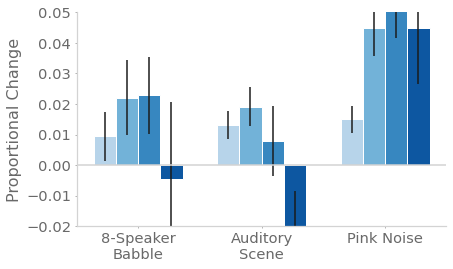

In [18]:
from scipy.stats import sem
import matplotlib.cm as cm
# width of the bars
barWidth = 0.18
x1 = np.arange(5) - barWidth*5/2
colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))

for bg_i, bg in enumerate(['Babble8Spkr', 'AudScene', 'pinkNoise']):
    for t in [1, 2, 3, 4]:
        vals = df[(df['BG']==bg) & (df['Timesteps']==t)]['Relative Accuracy (BG Corrected)']
        vals = np.array(vals)
        rel_avg = np.mean(vals)
        err = sem(vals)
        plt.bar(
            x1[bg_i] + barWidth*t, rel_avg,
            width=barWidth, color=colors[t-1],
            yerr=err, capsize=0, label=t)
plt.xticks(
    [0, 1, 2],
    ['8-Speaker\nBabble', 'Auditory\nScene', 'Pink Noise']
    )
plt.ylabel('Proportional Change')
plt.axhline(0, color='lightgray')
plt.ylim(-0.02, 0.05)
plt.tight_layout()
plt.savefig('../figures/mean_acc_by_bg.svg', dpi=300)
plt.show()

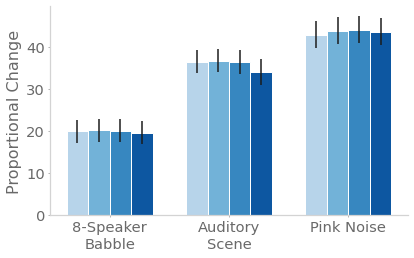

In [19]:
from scipy.stats import sem
import matplotlib.cm as cm
# width of the bars
barWidth = 0.18
x1 = np.arange(5) - barWidth*5/2
colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))

for bg_i, bg in enumerate(['Babble8Spkr', 'AudScene', 'pinkNoise']):
    for t in [1, 2, 3, 4]:
        vals = df[(df['BG']==bg) & (df['Timesteps']==t)]['Accuracy']
        vals = np.array(vals)
        rel_avg = np.mean(vals)
        err = sem(vals)
        plt.bar(
            x1[bg_i] + barWidth*t, rel_avg,
            width=barWidth, color=colors[t-1],
            yerr=err, capsize=0, label=t)
plt.xticks(
    [0, 1, 2],
    ['8-Speaker\nBabble', 'Auditory\nScene', 'Pink Noise']
    )
plt.ylabel('Proportional Change')
plt.show()

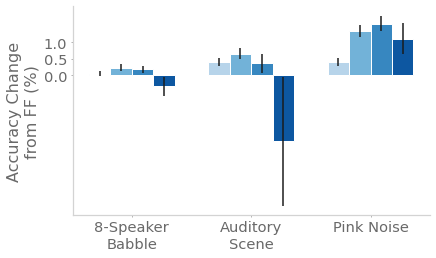

In [20]:
from scipy.stats import sem
import matplotlib.cm as cm
# width of the bars
barWidth = 0.18
x1 = np.arange(5) - barWidth*5/2
colors = cm.get_cmap('Blues')(np.linspace(0.3, 0.85, 4))
fig, ax = plt.subplots(figsize=(6.4, 4.8*0.8))

for bg_i, bg in enumerate(['Babble8Spkr', 'AudScene', 'pinkNoise']):
    for t in [1, 2, 3, 4]:
        vals = df[(df['BG']==bg) & (df['Timesteps']==t)]['Relative Accuracy']
        vals = np.array(vals)
        avg = np.mean(vals)
        err = sem(vals)
        plt.bar(
            x1[bg_i] + barWidth*t, avg,
            width=barWidth, color=colors[t-1],
            yerr=err, capsize=0, label=t)
plt.xticks(
    [0, 1, 2],
    ['8-Speaker\nBabble', 'Auditory\nScene', 'Pink Noise']
    )
plt.yticks([0., 0.5, 1.])
plt.ylabel('Accuracy Change\nfrom FF (%)')
plt.show()

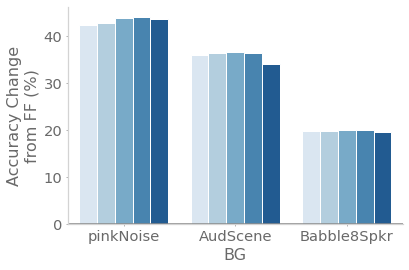

In [21]:
df = pd.DataFrame(data)
g = sns.barplot(
    x='BG', y='Accuracy', hue='Timesteps',
    data=df, ci=None,
    palette="Blues"
    )
g.legend_.remove()
plt.ylabel('Accuracy Change\nfrom FF (%)')
plt.axhline(0, color='gray')
plt.savefig('acc.svg', dpi=300)
plt.show(g)

# As percent fold change

In [ ]:
from ReconstructionTrainingDataset import NoisyDataset

In [ ]:
data2 = {}
data2['Timesteps'] = []
data2['Accuracy'] = []
data2['SNR'] = []
data2['BG'] = []
for bg in bgs:
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, accs = eval_accuracy(results, dset)
        data2['Timesteps'].extend(timesteps)
        data2['Accuracy'].extend([x*100 for x in accs])
        data2['SNR'].extend([snr]*len(accs))
        data2['BG'].extend([bg]*len(accs))

In [ ]:
df = pd.DataFrame(data2)
df = df[df['SNR']==-9.]
df2 = {}
df2['Accuracy'] = []
df2['BG'] = []
df2['Timestep'] = []
for bg in np.unique(df['BG']):
    avg = np.mean(df[(df['BG']==bg) & (df['Timesteps']==0)]['Accuracy'])
    for t in np.unique(df['Timesteps']):
        val = np.mean(df[(df['BG']==bg) & (df['Timesteps']==t)]['Accuracy'])
        norm_val = val/avg
        df2['Accuracy'].append(norm_val)
        df2['BG'].append(bg)
        df2['Timestep'].append(t)
df2 = pd.DataFrame(df2) 
g = sns.barplot(
    x='BG', y='Accuracy', hue='Timestep',
    data=df2, ci=None,
    palette="Blues"
    )
g.legend_.remove()
plt.ylabel('Fold Change\nfrom FF')
plt.axhline(0, color='gray')
plt.savefig('acc.svg', dpi=300)
plt.show(g)

# FF Incorrect, Clean Correct

In [ ]:
for bg in bgs:
    data = {}
    data['Timesteps'] = []
    data['Accuracy'] = []
    data['SNR'] = []
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, accs = eval_accuracy(
            results, dset, ff_correct=False, clean_correct=True
            )
        data['Timesteps'].extend(timesteps)
        data['Accuracy'].extend(accs)
        data['SNR'].extend([snr]*len(accs))
    df = pd.DataFrame(data)
    g = sns.lineplot(x='Timesteps', y='Accuracy', hue='SNR', data=df)
    plt.title(f'{bg}')
    plt.xticks([0, 1, 2, 3, 4])
    plt.show(g)

# FF Correct, Clean Correct

In [ ]:
for bg in bgs:
    data = {}
    data['Timesteps'] = []
    data['Accuracy'] = []
    data['SNR'] = []
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, accs = eval_accuracy(
            results, dset, ff_correct=True, clean_correct=True
            )
        data['Timesteps'].extend(timesteps)
        data['Accuracy'].extend(accs)
        data['SNR'].extend([snr]*len(accs))
    df = pd.DataFrame(data)
    g = sns.lineplot(x='Timesteps', y='Accuracy', hue='SNR', data=df)
    plt.title(f'{bg}')
    plt.xticks([0, 1, 2, 3, 4])
    plt.show(g)

# FF Incorrect, Clean Incorrect

In [ ]:
for bg in bgs:
    data = {}
    data['Timesteps'] = []
    data['Accuracy'] = []
    data['SNR'] = []
    for snr in snrs:
        dset = NoisyDataset(bg, snr)
        results_path = f'{activations_dir}{bg}_snr{int(snr)}.hdf5'
        results = h5py.File(results_path, 'r')
        timesteps, accs = eval_accuracy(
            results, dset, ff_correct=False, clean_correct=False
            )
        data['Timesteps'].extend(timesteps)
        data['Accuracy'].extend(accs)
        data['SNR'].extend([snr]*len(accs))
    df = pd.DataFrame(data)
    g = sns.lineplot(x='Timesteps', y='Accuracy', hue='SNR', data=df)
    plt.title(f'{bg}')
    plt.xticks([0, 1, 2, 3, 4])
    plt.show(g)